# Introduction

Some words about the dataset:

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser and each phrase has a PhraseId. Similarly, each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data through a data-cleaning procedure that is definied at a later stage.

The dataset contains two main sub-datasets:

*train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.

*test.tsv contains just phrases. Our goal for this assignment is to assign a sentiment label to each phrase.

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [1]:
import os
os.getcwd()

'C:\\Users\\jimis'

In [2]:
# Loading trivial and useful libraries to start our analysis

import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import re
import string
import nltk # The Natural Language Toolkit (NTLK), is a suitr of libraries and programms for symbolic and statistical natural processing
# for Emglish written in Python .
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoupan
from tqdm import tqdm #TQDM is a progress bar library with good support for nested loops and Jupiter/Python notebooks.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# Some words about Keras

Keras is a deep learning framework that actually under the hood uses other deep learning frameworks in order to expose a simple to use and work with high-level API. In our case, Keras will use the Tensorflow – Google’s deep learning library.

The integration with the various backends is seamless and comes in two flavors: sequential or functional. Just to ways of thinking about building models. 
The resulting models are perfectly equivalent. We’re going to use the sequential one, to develop various types of models for Natural Language Processing. 

*(Dense) Deep Neural Network – The NN classic model – uses the BOW model

*Convolutional Network – build a network using 1D Conv Layers – uses word vectors

*Recurrent Networks – LSTM Network – Long Short-Term Memory – uses word vectors

*Τransfer learning for NLP – uses word vectors

In [3]:
# Loading Keras and associated packages.

from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

# set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)

Using TensorFlow backend.


In [4]:
# Load Train and Test datasets.

train= pd.read_csv("train.tsv", sep="\t")
test = pd.read_csv("test.tsv", sep="\t")

In [5]:
# Let's have a first look at the train data...

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
train.shape # train's dataset dimensions.

(156060, 4)

In [7]:
# Let's have a look at the test data...

test.head() # same with train dataset without the sentiment column which we are going to predict.

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
test.shape # test's dataset dimensions

(66292, 3)

# Dataset's Cleaning Procedure

The next step is to create a function for cleaning the reviews, tokenize and lemmatize them.
This function will take each phrase iteratively and it will do the followings:
1. remove html content
2. remove non-alphabetic characters
3. tokenize the sentences
4. lemmatize each word to its lemma
5. return the result in the list named reviews.

In [9]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [10]:
# Cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [00:21<00:00, 3110.66it/s]


156060
66292


# Dataset's Pre-processing 

Before we start building our model, we have to perform some extra steps to transform our data in a form suitable for our RNN model.

These steps are:

1. Collect the dependent values and convert to one-hot encoded output using to_categorical

2. Split into train and validation datasets

3. Geting the no of unique words and max length of a review available in the list of cleaned reviews

4. Tokenizing and converting to sequences

5. Perform padding to equalize the lengths of all input reviews since LSTM networks needs all inputs to be same length

6. Define early-stopping threshold to prevent overfitting

In [11]:
# Collect the dependent values and convert to one-hot encoded output using to_categorical.

target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [12]:
# Split into train and validation datasets.

X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [13]:
# Geting the no of unique words and max length of a review available in the list of cleaned reviews.

#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words))) # number of unique words
print(len_max) # max length of a review

100%|██████████| 124848/124848 [00:00<00:00, 822878.83it/s]


13739
48


In [14]:
# Actual tokenizer of keras and convert to sequences.

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

# Arguments- texts: list of texts to turn to sequences.
# Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

# padding done to equalize the lengths of all input reviews since LSTM networks needs all inputs to be same length.
# Therefore reviews lesser than max length will be made equal using extra zeros at end. This technique is called 'padding'.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [15]:
# Early stopping to prevent overfitting
# Early stopping is a method that allows you to specify an arbitrary large number of training epochs 
# and stop training, once the model performance stops improving on a hold out validation dataset.

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

# Model's Architecture

In order to train the model, we are going to use a type of Recurrent Neural Network (RNN), known as LSTM (Long Short Term Memory). The main advantage of this network is that it is able to remember the sequence of past data i.e. words in our case in order to make a decision on the sentiment of the word. 

This architecture is specially designed to work on sequence data since it fits perfectly for many NLP tasks like tagging and text classification. More specifically, it treats the text as a sequence rather than a bag of words or as engrams.

This feature, allows the each cell to decide which of the past information to remember and the ones to forget, a great advantage in terms of performance's speed and memory's use.

We are going to create the network using Keras. 
Keras is built on tensorflow and can be used to build most types of deep learning models. We are going to specify the layers of the model as below. In order to estimate the parameters such as dropout, no of cells etc we have performed a grid search with different parameter values and chose the parameters with best performance.

# Model's Parameters

Activation Function: I have used ReLU as the activation function. ReLU is a non-linear activation function, which helps complex relationships in the data to be captured by the model.

Optimizer: We use adam optimiser, which is an adaptive learning rate optimizer.

Loss function: We will train a network to output a probability over the classes using Cross-Entropy loss, also called Softmax Loss. It is very useful for multi-class classification.

In [16]:
# Model using Keras LSTM

# Multilayer Perceptron (MLP) for multi-class softmax classification.

#The model's definition is the following:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4121700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)      

# Model's Fitting
We have run the training on a batch size of 256 items at a time. As you increase the batch size the time for training would reduce but it will require additional computational capacity. Hence it is a trade-off between computation capacity and time for training.

The training is set to run for 6 epochs. One epoch would mean that the network has seen the entire training data once. As we increase the number of epochs there is a risk that the model will overfit to the training data. Hence to prevent the model from overfitting we have enabled early stopping.

Early stopping is a method that allows us to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out/validation dataset.

In [17]:
# Fit the model

history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Instructions for updating:
Use tf.cast instead.
Train on 124848 samples, validate on 31212 samples
Epoch 1/6


 52224/124848 [===========>..................] - ETA: 16:04 - loss: 1.5989 - acc: 0.26 - ETA: 9:38 - loss: 1.5365 - acc: 0.3887 - ETA: 7:25 - loss: 1.4431 - acc: 0.441 - ETA: 6:18 - loss: 1.4092 - acc: 0.462 - ETA: 5:34 - loss: 1.3776 - acc: 0.473 - ETA: 5:07 - loss: 1.3629 - acc: 0.474 - ETA: 4:45 - loss: 1.3537 - acc: 0.477 - ETA: 4:28 - loss: 1.3477 - acc: 0.480 - ETA: 4:15 - loss: 1.3274 - acc: 0.490 - ETA: 4:05 - loss: 1.3172 - acc: 0.494 - ETA: 3:57 - loss: 1.3116 - acc: 0.495 - ETA: 3:50 - loss: 1.3088 - acc: 0.493 - ETA: 3:45 - loss: 1.3066 - acc: 0.493 - ETA: 3:39 - loss: 1.2979 - acc: 0.496 - ETA: 3:35 - loss: 1.2912 - acc: 0.499 - ETA: 3:31 - loss: 1.2851 - acc: 0.502 - ETA: 3:28 - loss: 1.2870 - acc: 0.500 - ETA: 3:25 - loss: 1.2854 - acc: 0.499 - ETA: 3:21 - loss: 1.2845 - acc: 0.499 - ETA: 3:19 - loss: 1.2818 - acc: 0.500 - ETA: 3:17 - loss: 1.2788 - acc: 0.501 - ETA: 3:14 - loss: 1.2774 - acc: 0.502 - ETA: 3:12 - loss: 1.2746 - acc: 0.502 - ETA: 3:11 - loss: 1.2728 - acc

 52224/124848 [===========>..................] - ETA: 3:58 - loss: 0.8996 - acc: 0.597 - ETA: 3:49 - loss: 0.8615 - acc: 0.621 - ETA: 3:39 - loss: 0.8638 - acc: 0.628 - ETA: 3:33 - loss: 0.8370 - acc: 0.643 - ETA: 3:41 - loss: 0.8314 - acc: 0.650 - ETA: 3:44 - loss: 0.8352 - acc: 0.648 - ETA: 3:44 - loss: 0.8274 - acc: 0.653 - ETA: 3:42 - loss: 0.8155 - acc: 0.661 - ETA: 3:43 - loss: 0.8259 - acc: 0.657 - ETA: 3:43 - loss: 0.8235 - acc: 0.657 - ETA: 3:43 - loss: 0.8165 - acc: 0.662 - ETA: 3:43 - loss: 0.8123 - acc: 0.665 - ETA: 3:42 - loss: 0.8069 - acc: 0.666 - ETA: 3:40 - loss: 0.8000 - acc: 0.668 - ETA: 3:39 - loss: 0.8074 - acc: 0.668 - ETA: 3:39 - loss: 0.8039 - acc: 0.666 - ETA: 3:38 - loss: 0.8057 - acc: 0.666 - ETA: 3:37 - loss: 0.8050 - acc: 0.665 - ETA: 3:36 - loss: 0.8035 - acc: 0.665 - ETA: 3:36 - loss: 0.8022 - acc: 0.665 - ETA: 3:36 - loss: 0.8012 - acc: 0.665 - ETA: 3:35 - loss: 0.8038 - acc: 0.665 - ETA: 3:35 - loss: 0.8010 - acc: 0.666 - ETA: 3:35 - loss: 0.8032 - acc:

124848/124848 [==============================] - ETA: 35s - loss: 0.8118 - acc: 0.66 - ETA: 34s - loss: 0.8118 - acc: 0.66 - ETA: 34s - loss: 0.8118 - acc: 0.66 - ETA: 33s - loss: 0.8118 - acc: 0.66 - ETA: 33s - loss: 0.8118 - acc: 0.66 - ETA: 32s - loss: 0.8116 - acc: 0.66 - ETA: 32s - loss: 0.8114 - acc: 0.66 - ETA: 31s - loss: 0.8115 - acc: 0.66 - ETA: 31s - loss: 0.8112 - acc: 0.66 - ETA: 30s - loss: 0.8112 - acc: 0.66 - ETA: 30s - loss: 0.8111 - acc: 0.66 - ETA: 29s - loss: 0.8113 - acc: 0.66 - ETA: 29s - loss: 0.8113 - acc: 0.66 - ETA: 28s - loss: 0.8114 - acc: 0.66 - ETA: 28s - loss: 0.8115 - acc: 0.66 - ETA: 28s - loss: 0.8116 - acc: 0.66 - ETA: 27s - loss: 0.8116 - acc: 0.66 - ETA: 27s - loss: 0.8117 - acc: 0.66 - ETA: 26s - loss: 0.8116 - acc: 0.66 - ETA: 26s - loss: 0.8117 - acc: 0.66 - ETA: 25s - loss: 0.8118 - acc: 0.66 - ETA: 25s - loss: 0.8118 - acc: 0.66 - ETA: 24s - loss: 0.8116 - acc: 0.66 - ETA: 24s - loss: 0.8114 - acc: 0.66 - ETA: 23s - loss: 0.8114 - acc: 0.66 - E

 52224/124848 [===========>..................] - ETA: 3:49 - loss: 0.6903 - acc: 0.703 - ETA: 3:53 - loss: 0.7078 - acc: 0.697 - ETA: 3:49 - loss: 0.7218 - acc: 0.699 - ETA: 3:48 - loss: 0.7281 - acc: 0.697 - ETA: 3:48 - loss: 0.7094 - acc: 0.707 - ETA: 3:47 - loss: 0.6980 - acc: 0.715 - ETA: 3:45 - loss: 0.7007 - acc: 0.712 - ETA: 3:43 - loss: 0.7099 - acc: 0.704 - ETA: 3:42 - loss: 0.7159 - acc: 0.700 - ETA: 3:40 - loss: 0.7172 - acc: 0.701 - ETA: 3:37 - loss: 0.7126 - acc: 0.703 - ETA: 3:35 - loss: 0.7199 - acc: 0.702 - ETA: 3:35 - loss: 0.7242 - acc: 0.701 - ETA: 3:34 - loss: 0.7249 - acc: 0.698 - ETA: 3:32 - loss: 0.7281 - acc: 0.700 - ETA: 3:32 - loss: 0.7270 - acc: 0.701 - ETA: 3:31 - loss: 0.7223 - acc: 0.701 - ETA: 3:30 - loss: 0.7216 - acc: 0.702 - ETA: 3:29 - loss: 0.7226 - acc: 0.700 - ETA: 3:29 - loss: 0.7218 - acc: 0.700 - ETA: 3:28 - loss: 0.7261 - acc: 0.697 - ETA: 3:26 - loss: 0.7259 - acc: 0.696 - ETA: 3:26 - loss: 0.7260 - acc: 0.696 - ETA: 3:26 - loss: 0.7260 - acc:

 52224/124848 [===========>..................] - ETA: 3:30 - loss: 0.7037 - acc: 0.742 - ETA: 3:32 - loss: 0.6472 - acc: 0.773 - ETA: 3:30 - loss: 0.6774 - acc: 0.753 - ETA: 3:27 - loss: 0.6511 - acc: 0.750 - ETA: 3:28 - loss: 0.6373 - acc: 0.750 - ETA: 3:32 - loss: 0.6450 - acc: 0.744 - ETA: 3:32 - loss: 0.6488 - acc: 0.739 - ETA: 3:33 - loss: 0.6383 - acc: 0.743 - ETA: 3:34 - loss: 0.6405 - acc: 0.740 - ETA: 3:34 - loss: 0.6415 - acc: 0.741 - ETA: 3:34 - loss: 0.6415 - acc: 0.740 - ETA: 3:35 - loss: 0.6441 - acc: 0.739 - ETA: 3:36 - loss: 0.6508 - acc: 0.735 - ETA: 3:36 - loss: 0.6527 - acc: 0.734 - ETA: 3:36 - loss: 0.6544 - acc: 0.736 - ETA: 3:35 - loss: 0.6551 - acc: 0.735 - ETA: 3:36 - loss: 0.6541 - acc: 0.736 - ETA: 3:36 - loss: 0.6528 - acc: 0.734 - ETA: 3:36 - loss: 0.6518 - acc: 0.736 - ETA: 3:37 - loss: 0.6519 - acc: 0.735 - ETA: 3:37 - loss: 0.6534 - acc: 0.733 - ETA: 3:36 - loss: 0.6520 - acc: 0.735 - ETA: 3:36 - loss: 0.6516 - acc: 0.735 - ETA: 3:36 - loss: 0.6489 - acc:

124848/124848 [==============================] - ETA: 34s - loss: 0.6965 - acc: 0.70 - ETA: 33s - loss: 0.6966 - acc: 0.70 - ETA: 33s - loss: 0.6964 - acc: 0.70 - ETA: 33s - loss: 0.6965 - acc: 0.70 - ETA: 32s - loss: 0.6963 - acc: 0.70 - ETA: 32s - loss: 0.6964 - acc: 0.70 - ETA: 31s - loss: 0.6966 - acc: 0.70 - ETA: 31s - loss: 0.6967 - acc: 0.70 - ETA: 30s - loss: 0.6968 - acc: 0.70 - ETA: 30s - loss: 0.6970 - acc: 0.70 - ETA: 29s - loss: 0.6969 - acc: 0.70 - ETA: 29s - loss: 0.6970 - acc: 0.70 - ETA: 28s - loss: 0.6970 - acc: 0.70 - ETA: 28s - loss: 0.6970 - acc: 0.70 - ETA: 28s - loss: 0.6971 - acc: 0.70 - ETA: 27s - loss: 0.6970 - acc: 0.70 - ETA: 27s - loss: 0.6971 - acc: 0.70 - ETA: 26s - loss: 0.6970 - acc: 0.70 - ETA: 26s - loss: 0.6970 - acc: 0.70 - ETA: 25s - loss: 0.6973 - acc: 0.70 - ETA: 25s - loss: 0.6970 - acc: 0.70 - ETA: 24s - loss: 0.6969 - acc: 0.70 - ETA: 24s - loss: 0.6970 - acc: 0.70 - ETA: 23s - loss: 0.6973 - acc: 0.70 - ETA: 23s - loss: 0.6974 - acc: 0.70 - E

 52224/124848 [===========>..................] - ETA: 3:39 - loss: 0.6301 - acc: 0.730 - ETA: 3:38 - loss: 0.6141 - acc: 0.748 - ETA: 3:42 - loss: 0.6246 - acc: 0.746 - ETA: 3:38 - loss: 0.6301 - acc: 0.745 - ETA: 3:35 - loss: 0.6364 - acc: 0.737 - ETA: 3:35 - loss: 0.6437 - acc: 0.728 - ETA: 3:33 - loss: 0.6316 - acc: 0.734 - ETA: 3:31 - loss: 0.6309 - acc: 0.735 - ETA: 3:29 - loss: 0.6260 - acc: 0.738 - ETA: 3:30 - loss: 0.6352 - acc: 0.729 - ETA: 3:29 - loss: 0.6307 - acc: 0.730 - ETA: 3:27 - loss: 0.6277 - acc: 0.732 - ETA: 3:27 - loss: 0.6264 - acc: 0.733 - ETA: 3:26 - loss: 0.6255 - acc: 0.731 - ETA: 3:24 - loss: 0.6279 - acc: 0.731 - ETA: 3:25 - loss: 0.6321 - acc: 0.730 - ETA: 3:27 - loss: 0.6308 - acc: 0.730 - ETA: 3:28 - loss: 0.6369 - acc: 0.730 - ETA: 3:29 - loss: 0.6428 - acc: 0.729 - ETA: 3:29 - loss: 0.6441 - acc: 0.728 - ETA: 3:30 - loss: 0.6432 - acc: 0.728 - ETA: 3:31 - loss: 0.6414 - acc: 0.727 - ETA: 3:31 - loss: 0.6377 - acc: 0.729 - ETA: 3:31 - loss: 0.6362 - acc:

# Model's Performance and Learning's curve visualization
We are going to visualize the behavior of the learning curve both for training and validation datasets to check the performance of our model in an understandable way.

A learning curve is a plot of model learning performance over experience or time or more simply, it is a line plot of learning (y-axis) over experience (x-axis).

Learning curves are a widely used diagnostic tool in machine and deep learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a holdout validation dataset after each update during training and plots of the measured performance can created to show learning curves.

Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model, as well as whether the training and validation datasets are suitably representative.

During the training of a machine learning model, the current state of the model at each step of the training algorithm can be evaluated. It can be evaluated on the training dataset to give an idea of how well the model is “learning.” It can also be evaluated on a hold-out validation dataset that is not part of the training dataset. Evaluation on the validation dataset gives an idea of how well the model is “generalizing.”

•	Train Learning Curve: Learning curve calculated from the training dataset that gives an idea of how well the model is learning.

•	Validation Learning Curve: Learning curve calculated from a hold-out validation dataset that gives an idea of how well the model is generalizing.


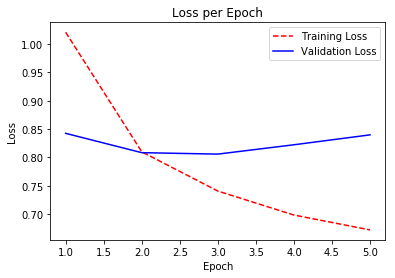

In [20]:
# Visualize learning curve. 

import matplotlib.pyplot as plt
%matplotlib inline

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

In [19]:
# Finally, we make the predictions with trained model.
y_pred=model.predict_classes(X_test)
print (y_pred)

[2 2 3 ... 1 1 2]
